## ANN dMap h2t Takens latent space -> dMap all-atom latent space

In [1]:

import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import math
import time
import pickle
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
from torch import nn #import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.parallel
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data
from torch.utils.data.dataset import random_split


import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split

from collections import OrderedDict

import mdtraj as md

device = torch.device("cpu")

In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2'''

# fix random seed for reproducibility
np.random.seed(200186)
torch.manual_seed(200186)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(200186)
    
pdb_dir = "/home/maxtopel/Desktop/History/Gaussian Mol Rec/mol rec/Chignolin_partial/"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = "/home/maxtopel/Desktop/History/Gaussian Mol Rec/mol rec/Chignolin_partial/CLN2025-0-protein/"
trj_file = []
for i in range(10):
    fname = "CLN025-0-protein-00" + str(i) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
for i in range(10,54):
    fname = "CLN025-0-protein-0" + str(i) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))

# loading
traj = md.load(trj_file, top=pdb_file)
# restricting atoms in trajectory
idx_atoms = traj.topology.select_atom_indices('heavy') # 'heavy' OR 'minimal' OR 'all'
traj = traj.atom_slice(idx_atoms)

# rot+trans alignment of trajectory to first frame
traj.center_coordinates(mass_weighted=False)
traj.superpose(traj[0])

In [3]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

#npzfile = np.load('/home/maxtopel/Desktop/History/Gaussian Mol Rec/mol rec/Chignolin_partial/h2t.npz')
#sorted(npzfile.files)
#h2t = npzfile['h2t']

### All in


In [4]:
tau = [1,5,10,25,50]

Dvec = [40000,20000,10000,1000] #20000,10000,1000
#,20000,10000,1000


#no of observed photons
#Photon_No  = [0,1000000,100000,10000,1000]

Photon_No  = [0,1000000,100000,10000]#,100000,10000,1000]



iii = 0



for Dv in Dvec:
    for t in tau:
        for Nv in Photon_No:
            
            npzfile = np.load('../../Short Circuit/0A_aa_h2t/h2t_%fns.npz' %(t*0.2)) 
            sorted(npzfile.files)
            h2t = npzfile['h2t_train']
    
            indx = []
            dim = 11
            j = 0
            # Train in 40k data points
            stopframe = Dv
            #Chose over first 450000
            totframe = int(round(len(h2t)*0.8))
            # number of pieces
            nohist = 10
            #train 10 percent on each ile
            ratio = 1/nohist
            #print(stopframe,totframe)

            #find histogram values
            no = list(np.histogram(h2t[0:totframe],bins=nohist)[0])
            val = list(np.histogram(h2t[0:totframe],bins=nohist)[1][0:nohist])
            val.insert(0,0)

            #print(len(h2t), val)
            #iterate over the number of histogram divisions
            for ile in range(nohist):
                #print(ile)
                # iterate over all frames
                for i in range(totframe):
                    #iterate over deciles
                    #print(stopframe*ratio*(ile+1))
                    if j < stopframe*ratio*(ile+1):
                        # select that it is in the correct decile
                        if h2t[i] < val[ile+1] and h2t[i] > val[ile]:
                            for d in range(-dim//2+1,dim//2+1):
                                if (i+d) not in indx:
                                    #print(i-d)
                                    indx.append(i+d)
                                    j += 1
                                    #print(i-d)
                                    #print(indx[])

                    elif j >= stopframe:
                        #print(ile,i,j)
                        break

            #    print(len(indx))
                
                
                
            # loading z_aa
            npzfile = np.load('../../Short Circuit/1A_dMap_aa/data_%dk_%fns.npz' %(Dv,t*0.2))
           # sorted(npzfile.files)
            z_aa = npzfile['z']
            
         #   test = np.array(range(len(z_aa)))
          #  for i in range(len(indx)):
           #     test.remove(indx[i])
            
            z_aa_features_idx = np.array([1,2])
            z_aa = z_aa[:,z_aa_features_idx]

            n_aa = z_aa.shape[0]
            d_aa = z_aa.shape[1]

            # scaling
            zscale_aa = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling AND use of loss other than BCE

            Z_aa = zscale_aa.fit_transform(z_aa)

            # saving scaling associated with model
            D = {}
            D['zscale'] = zscale_aa
            file = open('ANN_z_aa_scaling_%dk_%dphoton_%fns.pkl' %(Dv,Nv,t*0.2), 'wb')
            pickle.dump(D, file)
            file.close()

            #D = pickle.load(open("ANN_z_aa_scaling.pkl", "rb"))
            #zscale = D['zscale']

            # loading z_Takens
            npzfile = np.load('../3A_dMap_h2t/data_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2))
            #sorted(npzfile.files)
            z_Takens = npzfile['z']

            z_Takens_features_idx = np.array([1,2])

            z_Takens = z_Takens[:,z_Takens_features_idx]

            n_Takens = z_Takens.shape[0]
            d_Takens = z_Takens.shape[1]

            zscale_Takens = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling AND use of loss other than BCE

            Z_Takens = zscale_Takens.fit_transform(z_Takens)

            # saving scaling associated with model
            D = {}
            D['zscale'] = zscale_Takens
            file = open('ANN_z_Takens_scaling_%dk_%dphoton_%fns.pkl' %(Dv,Nv,t*0.2), 'wb')
            pickle.dump(D, file)
            file.close()

            z_aa = z_aa[:z_Takens.shape[0],:]
            Z_aa = Z_aa[:Z_Takens.shape[0],:]

            assert z_aa.shape[0] == Z_aa.shape[0]
            assert z_aa.shape[0] == z_Takens.shape[0]
            assert z_aa.shape[0] == Z_Takens.shape[0]

            class ANN(nn.Module):
                def __init__(self, q, d_in, d_out):
                    super(ANN, self).__init__()
                    self.hidden1 = nn.Linear(d_in, np.int(np.ceil(q*d_in)))
                    self.hidden2 = nn.Linear(np.int(np.ceil(q*d_in)), np.int(np.ceil(q*d_in)))
                    self.hidden3 = nn.Linear(np.int(np.ceil(q*d_in)), np.int(np.ceil(q*d_in)))
                    self.hidden4 = nn.Linear(np.int(np.ceil(q*d_in)), np.int(np.ceil(q*d_in)))
                    self.output = nn.Linear(np.int(np.ceil(q*d_in)), d_out)

                def forward(self, x):
                    x = torch.tanh(self.hidden1(x))
                    x = torch.tanh(self.hidden2(x))
                    x = torch.tanh(self.hidden3(x))
                    x = torch.tanh(self.hidden4(x))
                    x = torch.tanh(self.output(x))
                    return x

            activation = {}

            class CustomDataset(Dataset):
                def __init__(self, x_tensor, y_tensor):
                    self.x = x_tensor
                    self.y = y_tensor

                def __getitem__(self, index):
                    return (self.x[index], self.y[index])

                def __len__(self):
                    return len(self.x)

            x_tensor = torch.from_numpy(Z_Takens).float()
            y_tensor = torch.from_numpy(Z_aa).float()
            assert x_tensor.shape[0] == y_tensor.shape[0]

            idx = np.arange(x_tensor.shape[0])

            val_frac = 0.10
            idx_train, idx_val = train_test_split(idx, test_size=val_frac, random_state=42)

            train_dataset = CustomDataset(x_tensor[idx_train], y_tensor[idx_train])
            val_dataset = CustomDataset(x_tensor[idx_val], y_tensor[idx_val])

            q=5.

            model = ANN(q, d_Takens, d_aa).to(device)

            #save_path = "./ANN.pyt"
            #model.load_state_dict(torch.load(save_path, map_location=device))

            lr = 1e-4
            n_epochs = 100
            batch_size = 500

            loss_fn = nn.MSELoss(reduction='elementwise_mean')
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

            train_step = make_train_step(model, loss_fn, optimizer)

            n_batch = math.ceil(1. * len(train_dataset) / batch_size)

            loss_train = np.zeros(n_epochs)
            loss_val = np.zeros(n_epochs)

            start=time.time()

            for epoch in range(n_epochs):    

                dataset = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

                model.train()

                batch_idx = 0
                for train_in, train_out in dataset:
                    train_in, train_out = train_in.to(device), train_out.to(device)
                    out = model(train_in)
                    loss = loss_fn(out, train_out) 
                    optimizer.zero_grad()
                    loss.backward() # scalar variables, when we call .backward() on them, don’t require arguments – only tensors require a matching sized tensor argument to be passed to the .backward() operation
                    optimizer.step()
                    batch_idx += 1

                model.eval()

                y_pred = model(train_dataset.x.to(device))
                diff = y_pred.cpu().detach().numpy() - train_dataset.y.cpu().detach().numpy()
                MSE = np.mean(diff**2)
                loss_train[epoch] = MSE

                y_pred = model(val_dataset.x.to(device))
                diff = y_pred.cpu().detach().numpy() - val_dataset.y.cpu().detach().numpy()
                MSE = np.mean(diff**2)
                loss_val[epoch] = MSE        

                #if np.mod(epoch+1,1) == 0:
                 #   print('====> Epoch %d of %d done! Train loss = %.2e, Val loss = %.2e' % (epoch+1,n_epochs,loss_train[epoch],loss_val[epoch]))

            end = time.time()
            #print("Using device = %s" % device)
            #print("Elapsed time %.2f (s)" % (end - start))

            save_path = "./ANN_%dk_%dphoton_%fns.pyt" %(Dv,Nv,t*0.2)
            torch.save(model.state_dict(), save_path)

            # INPUTS

            # loading z_Takens
            npzfile = np.load('../3A_dMap_h2t/data_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2))
           # sorted(npzfile.files)
            z_Takens = npzfile['z']

            # extracting features
            z_Takens = z_Takens[:,z_Takens_features_idx]

            # loading z_Takens scaling
            D = pickle.load(open("../4A_ANN_dMapaa2dMaph2t/ANN_z_Takens_scaling_%dk_%dphoton_%fns.pkl" %(Dv,Nv,t*0.2), "rb"))
            zscale_Takens = D['zscale']

            # scaling data
            Z_Takens = zscale_Takens.transform(z_Takens)

            # loading z_aa
            npzfile = np.load('../../Short Circuit/1A_dMap_aa/data_%dk_%fns.npz' %(Dv,t*0.2))
            #sorted(npzfile.files)
            z_aa = npzfile['z']

            # extracting features
            z_aa = z_aa[:,z_aa_features_idx]

            # loading z_aa scaling
            D = pickle.load(open("ANN_z_aa_scaling_%dk_%dphoton_%fns.pkl" %(Dv,Nv,t*0.2), "rb"))
            zscale_aa = D['zscale']

            # scaling data
            Z_aa = zscale_aa.transform(z_aa)

            # trimming data
            z_aa = z_aa[:Z_Takens.shape[0]]
            Z_aa = Z_aa[:Z_Takens.shape[0]]

            # initializing storage arrays
            Z_aa_pred = np.zeros(shape=(0,Z_aa.shape[1]), dtype=float)

            # running all data through model
            # N.B. running as batches so as not to max out GPU memory
            nSamples = Z_Takens.shape[0]
            maxBatchSz = 10000
            assert nSamples >= maxBatchSz
            nBatch = np.ceil(np.float(nSamples)/np.float(maxBatchSz)).astype(int)
            batchEdges = np.floor(np.linspace(0,nSamples,nBatch+1)).astype(int)

            #print('Running data through trained network...')
            for i in range(nBatch):
                data = torch.FloatTensor(Z_Takens[batchEdges[i]:batchEdges[i+1],:])
                data = Variable(data, requires_grad=False)
                data = data.to(device)
                model.eval()
                pred = model(data)

                Z_aa_pred_i = pred.cpu().detach().numpy()

                Z_aa_pred = np.append(Z_aa_pred,Z_aa_pred_i,axis=0)

               # print('\tProcessed batch %d/%d...' % (i+1,nBatch))

           # print('DONE!')
            #print('')

            z_aa_pred = zscale_aa.inverse_transform(Z_aa_pred)

            # scaled MSE
            diff = Z_aa_pred - Z_aa
            MSE = np.mean(diff**2)
            #print('MSE_test = %.2e' % MSE)
            #print('RMSE_test = %.2e' % np.sqrt(MSE))
            #print('')

            # unscaled MSE
            diff = z_aa_pred - z_aa
            MSE = np.mean(diff**2)
            #print('MSE_test = %.2e' % MSE)
            #print('RMSE_test = %.2e' % np.sqrt(MSE))
            #print('')

            # saving latent space projections
            np.savez('ANN_pred_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2), z_aa=z_aa_pred)
            #npzfile = np.load('ANN_pred.npz')
            #sorted(npzfile.files)
            #z = npzfile['z_aa']

            # initializing storage arrays
            Z_aa_pred = np.zeros(shape=(0,Z_aa.shape[1]), dtype=float)

            # running all data through model
            # N.B. running as batches so as not to max out GPU memory
            nSamples = Z_Takens.shape[0]
            maxBatchSz = 10000
            assert nSamples >= maxBatchSz
            nBatch = np.ceil(np.float(nSamples)/np.float(maxBatchSz)).astype(int)
            batchEdges = np.floor(np.linspace(0,nSamples,nBatch+1)).astype(int)

            #print('Running data through trained network...')
            for i in range(nBatch):
                data = torch.FloatTensor(Z_Takens[batchEdges[i]:batchEdges[i+1],:])
                data = Variable(data, requires_grad=False)
                data = data.to(device)
                model.eval()
                pred = model(data)

                Z_aa_pred_i = pred.cpu().detach().numpy()

                Z_aa_pred = np.append(Z_aa_pred,Z_aa_pred_i,axis=0)

             #   print('\tProcessed batch %d/%d...' % (i+1,nBatch))

            #print('DONE!')
            #print('')

            z_aa_pred = zscale_aa.inverse_transform(Z_aa_pred)

            # scaled MSE
            diff_ = Z_aa_pred - Z_aa
            s_MSE = np.mean(diff**2)
            s_RMSE = np.sqrt(s_MSE)
            #print('MSE_test = %.2e' % MSE)
            #print('RMSE_test = %.2e' % np.sqrt(MSE))
            #print('')

            # unscaled MSE
            diff = z_aa_pred - z_aa
            u_MSE = np.mean(diff**2)
            u_RMSE = np.sqrt(u_MSE)
            #print('MSE_test = %.2e' % MSE)
            #print('RMSE_test = %.2e' % np.sqrt(MSE))
            #print('')

            # saving latent space projections
            np.savez('ANN_pred_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2), z_aa=z_aa_pred)
            #npzfile = np.load('ANN_pred.npz')
            #sorted(npzfile.files)
            #z = npzfile['z_aa']
            np.savez('MSE_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2), u_MSE=u_MSE, u_RMSE=u_RMSE, s_RMSE=s_RMSE, s_MSE=s_MSE )
            iii +=1
            print('\tProcessed model %d/%d' %(iii,len(tau)*len(Dvec)*len(Photon_No)))

/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 1/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 2/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 3/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 4/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 5/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 6/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 7/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 8/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 9/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 10/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 11/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 12/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 13/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 14/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 15/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 16/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 17/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 18/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 19/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 20/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 21/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 22/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 23/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 24/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 25/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 26/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 27/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 28/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 29/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 30/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 31/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 32/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 33/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 34/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 35/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 36/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 37/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 38/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 39/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 40/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 41/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 42/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 43/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 44/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 45/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 46/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 47/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 48/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 49/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 50/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 51/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 52/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 53/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 54/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 55/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 56/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 57/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 58/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 59/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 60/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 61/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 62/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 63/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 64/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 65/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 66/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 67/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 68/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 69/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 70/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 71/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 72/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 73/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 74/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 75/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 76/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 77/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 78/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 79/80


/home/maxtopel/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


	Processed model 80/80


In [3]:
#FORMAT THE LABELING FOR AXES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



#xmax xmin system good: calibrate with extreme values then put in bounds
#label:
#1) 5 y, 10 x with linspace
#2) round to 3 sig fig.
#3) size 46 std

xrng = np.linspace(xmin,xmax,5)
yrng = np.linspace(ymin,ymax,5)
xlrng = np.linspace(xmin,xmax,5)
ylrng = np.linspace(ymin,ymax,5)

xrng = [item * 1e-7 for item in xrng]
yrng = [item * 1e-7 for item in yrng]

for i in range(len(xrng)):
   # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
    xrng[i] = np.format_float_scientific(xrng[i],precision=0,trim='-')#format(np.float(),'.7e'))
    
    #xrng[i] = np.float("{:g}".format(xrng[i]))#,'.e'))
    #xrng[i] = "{:2e}".format(xrng[i])
    #xrng[i] = str(float(xrng[i]))#,'.e')
   # xrng[i] = format(xrng[i],'.3e')
    

for i in range(len(yrng)):
    yrng[i] = np.format_float_scientific(yrng[i],precision=0,trim='-')
    #yrng[i] =
print(xrng,yrng)

NameError: name 'xmin' is not defined

In [3]:
#LABELING MATRIX
xlbl = [[],[],[],[],[]]
ylbl = [[],[],[],[],[]]

xlbl[0]=['-9.e-05', '-4.e-05',  '2.e-05',  '7.e-05',  '1.e-04']
ylbl[0]=['-9.e-05', '-4.e-05',  '2.e-06',  '5.e-05',  '9.e-05']

xlbl[1]=['-9.e-05', '-6.e-05', '-4.e-05', '-6.e-06',  '2.e-05']
ylbl[1]=['-6.e-05', '-4.e-05', '-6.e-06',  '2.e-05',  '5.e-05']

xlbl[2]=['-1.e-04', '-7.e-05', '-4.e-05', '-1.e-05',  '1.e-05']
ylbl[2]=['-6.e-05', '-3.e-05', '-6.e-06',  '2.e-05',  '5.e-05']

xlbl[3]=['-5.e-05', '-3.e-05', '-2.e-05',  '2.e-06',  '2.e-05']
ylbl[3]=['-6.e-05', '-4.e-05', '-1.e-05',  '1.e-05',  '4.e-05']


xlbl[4]=['-3.e-05', '-1.e-05',  '7.e-08',  '1.e-05',  '3.e-05']
ylbl[4]=['-6.e-05', '-3.e-05', '-9.e-06',  '2.e-05',  '4.e-05']



1670 1839
-10.0252547056068
[-9.e-05 -4.e-05  7.e-06  6.e-05  1.e-04]
[-9.e-05 -4.e-05  4.e-06  5.e-05  1.e-04]


NameError: name 'xlbl' is not defined

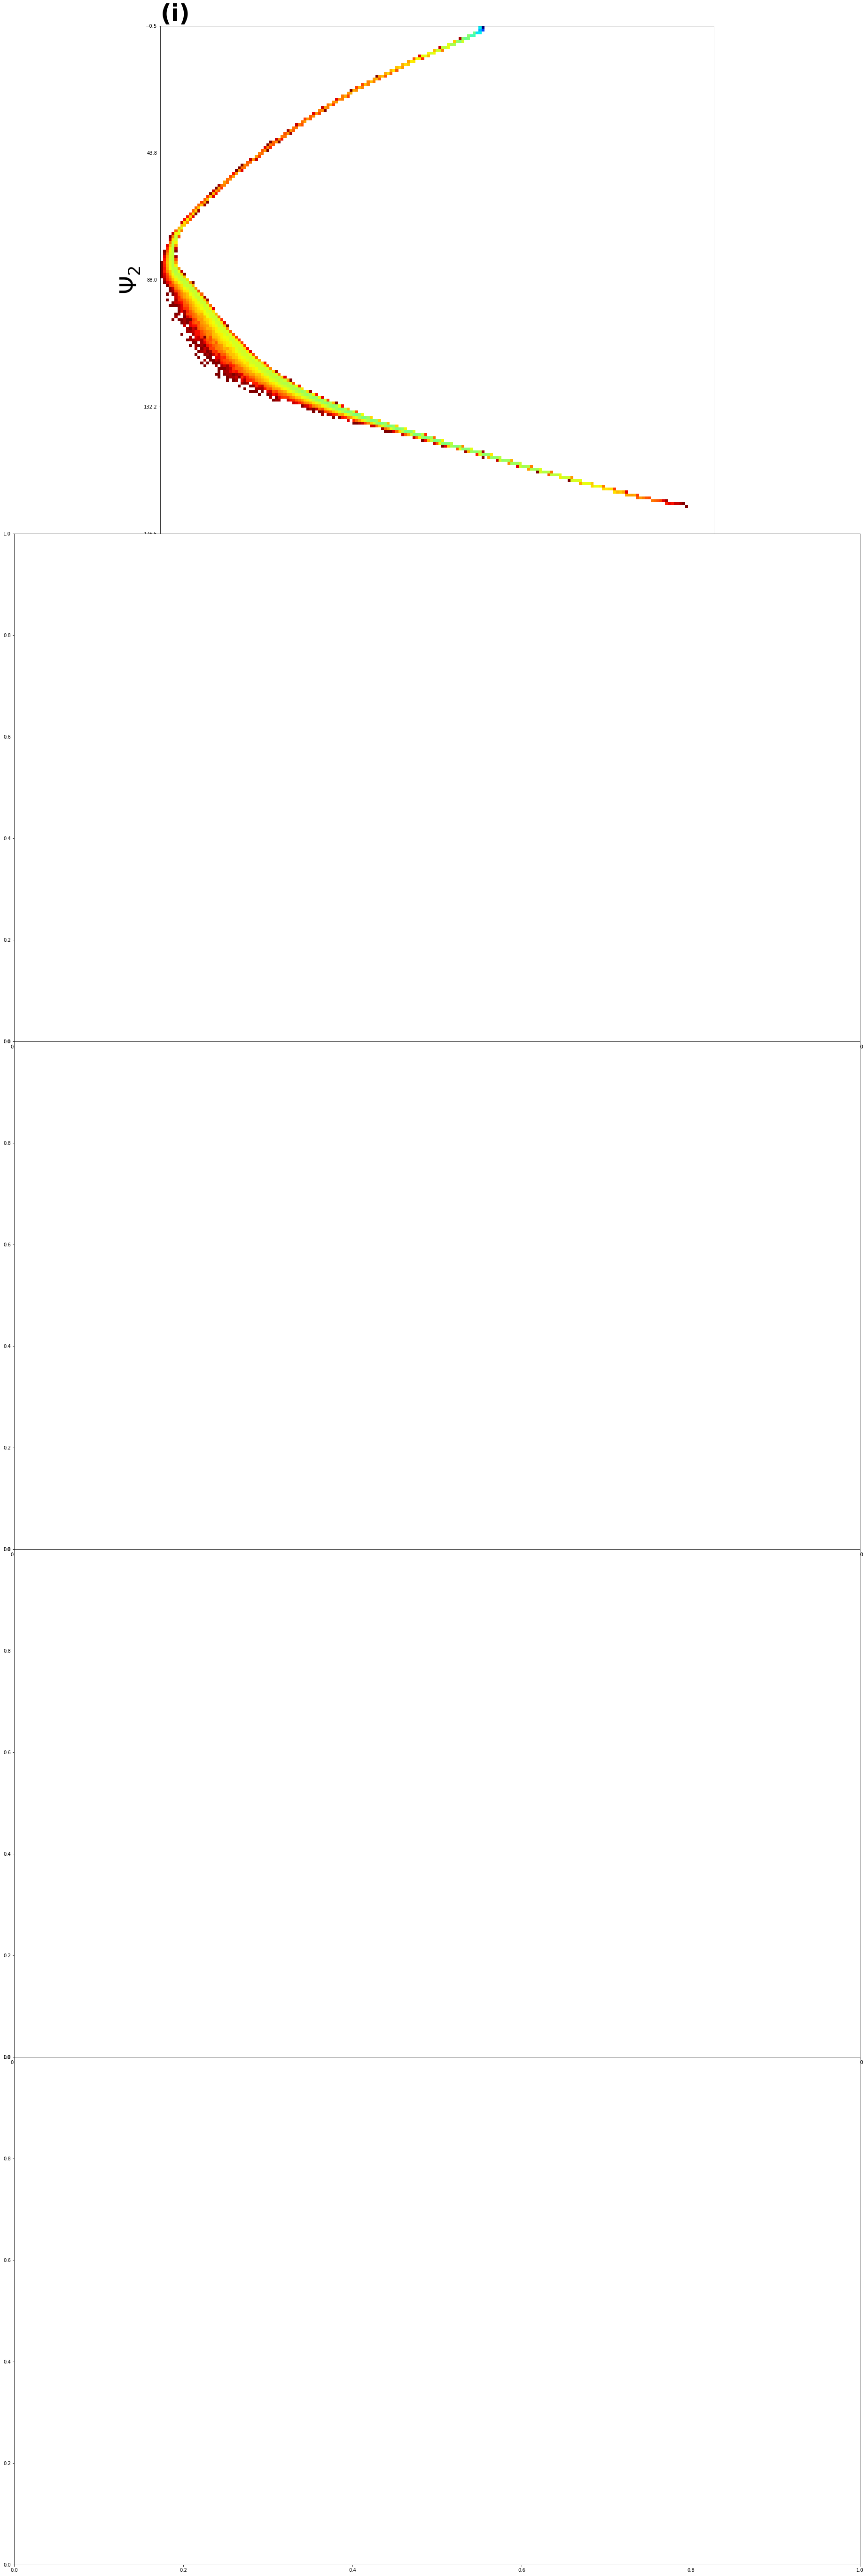

In [3]:

#ONE PLOT STYLE

#bin_sizes = [1,5,10,25,50]
Dvec = [40000] #,20000,10000,1000 
tau = [1,5,10,25,50]

#Dvec = [40000,20000,10000,1000] #20000,10000,1000
#,20000,10000,1000


#no of observed photons


#Photon_No  = [0,1000000,100000,10000,1000]
Nv  = 100000

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

fig, ax = plt.subplots(len(tau),figsize=(25, 15*len(tau)))


mpl.rc('xtick', labelsize=50) 
mpl.rc('ytick', labelsize=50)

for Dv in Dvec:
    for binsz in tau:
        t = binsz
        flag = 0
        npzfile = np.load('ANN_pred_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2))
        z = npzfile['z_aa']
        zp = z#[:,[1,2]]
        if binsz==1:
            zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        
        
        
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/1e-7),int((two_max-two_min)/1e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /=1e-6
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/1e-6)+10
        d_y = int((two_max-two_min)/1e-6)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
       # fig, ax = plt.subplots(2,figsize=(25, 15*len(bin_sizes)))
       # fig, ax = plt.subplots(figsize=(25, 15))
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
       # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.5)
        ax[icount].imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=12.5)
        ax[icount].set_xlabel('$\Psi_1$', fontsize=50)
        ax[icount].set_ylabel('$\Psi_2$', fontsize=50)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
        axes = ['(i)','(ii)','(iii)','(iv)','(v)']
        ax[icount].set_title(axes[icount],loc='left',fontsize=50,fontweight="bold")

       # ax[icount].set_xlim(left = xmin,right = xmax)
     #   ax[icount].set_ylim(ymin-10,ymax)
        
         
        yl = ax[icount].get_ylim()
        xl = ax[icount].get_xlim()
                     
        yrng = np.linspace(one_min*1.1,one_max*1.1,5)
        xrng =  np.linspace(two_min*1.1,two_max*1.1,5)
       
        xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
       # xlrng = np.linspace(float(xl[0])-0.1*float(xl[0]),float(xl[1])+0.1*float(xl[1]),5) 
        #ylrng = np.linspace(float(yl[0])+0.1*float(yl[0]),float(yl[1])-0.1*float(yl[1]),5)
        
   #     xlrng = np.linspace(0,d_x+10,5)
   #     ylrng = np.linspace(0,d_y+10,5)
    #
        #ax1.set_yticklabels(["one", "two", "three", "four"], rotation=45)
        
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=0,trim='-')#format(np.float(),'.7e'))
        print(xrng)
        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=0,trim='-')
        print(yrng)

        
        ax[icount].set_xticks(xlrng)
        ax[icount].set_yticks(ylrng)
     
        #ax[icount].tick_params(axis='x', labelrotation=60)
        ax[icount].set_xticklabels(xlbl[icount],rotation=60)
        ax[icount].set_yticklabels(ylbl[icount])
        
        
        ax[icount].arrow(zp[17230,1], zp[17230,0], 0,-50, head_width = 30-3*icount, width = 8-icount,color='black')
        ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 50, head_width = 30-3*icount, width = 8-icount,color='black')
        ax[icount].arrow(zp[40100,1], zp[40100,0], 0, -50, head_width = 30-3*icount, width = 8-icount,color='black')
        ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -50, head_width = 30-3*icount, width = 8-icount,color='black')
        ax[icount].arrow(zp[83065,1], zp[83065,0]+10, -50, 0, head_width = 30-3*icount, width = 8-icount,color='black')
        
        ax[icount].text(zp[17230,1]-20+2*icount, zp[17230,0]-80+icount*1, 'a',fontsize=50)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        ax[icount].text(zp[27211,1]-20+2*icount, zp[27211,0]+100*1.3-5*icount, 'b',fontsize=50)
        ax[icount].text(zp[40100,1]-20+2*icount, zp[40100,0]-70*1.5+7*icount, 'c',fontsize=50)
        ax[icount].text(zp[58718,1]-20+2*icount, zp[58718,0]-80*1.3+5*icount, 'd',fontsize=50)
        ax[icount].text(zp[83065,1]-80 +2*icount-50, zp[83065,0]+30, 'e',fontsize=50)
        
        #ax[icount].arrow(zp[17230,1], zp[17230,0], -50+3*icount,5, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 80-5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[40100,1], zp[40100,0], 0, 45-5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -80+5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[83065,1], zp[83065,0], 70-5*icount, 70-5*icount, head_width = 20, width = 5,color='black')
        
        #ax[icount].text(zp[17230,1]-80*1.3+7*icount, zp[17230,0]+15-icount*1, 'a',fontsize=50)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        #ax[icount].text(zp[27211,1] -15, zp[27211,0]+100*1.3-5*icount, 'b',fontsize=50)
        #ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]+65*1.5-7*icount, 'c',fontsize=50)
        #ax[icount].text(zp[58718,1]+ -20+icount*2 , zp[58718,0]-80*1.3+5*icount, 'd',fontsize=50)
        #ax[icount].text(zp[83065,1]+ 80 -5*icount, zp[83065,0]+80*1.3-5*icount+10, 'e',fontsize=50)
        
        #plt.xticks(xlrng,xrng,fontsize=80)
       ## plt.yticks(ylrng,yrng,fontsize=46)
        #plt.tick_params(axis='x', labelrotation=60)
       
        
        #plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        icount +=1
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=50)
        #plt.scatter(zp[58718,1], zp[58718,0], facecolor='magenta',s=300)
        #plt.scatter(zp[40100,1], zp[40100,0], facecolor='cyan',s=300)
        #plt.scatter(zp[27211,1], zp[27211,0], facecolor='green',s=300)
        #plt.scatter(zp[17230,1], zp[17230,0], facecolor='blue',s=300)
        #plt.scatter(zp[83065,1], zp[83065,0], facecolor='yellow',s=300)
        #print()
        
        #findglobal min and max
        #if one_max>xmax:
         #   xmax = one_max
        #if one_min<xmin:
        #    xmin = one_min
        #if two_max>ymax:
         #   ymax = two_max
        #if two_min<ymin:
         #   ymin = two_min
        #findglobal min and max
    
        #plt.gca().invert_yaxis()
    fig.tight_layout(rect=[0,0,0.99,0.99])    
    plt.show()
     
    fig.savefig('Chignolin_smFES_var_tau.png', dpi=300)
        
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

In [ ]:

#ONE PLOT STYLE

#bin_sizes = [1,5,10,25,50]
Dvec = [40000,20000,10000,1000] 
tau = [5]


#Dvec = [40000,20000,10000,1000] #20000,10000,1000
#,20000,10000,1000


#no of observed photons


#Photon_No  = [0,1000000,100000,10000,1000]
Nv  = 100000

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

#fig, ax = plt.subplots(len(tau),figsize=(25, 15*len(tau)))


mpl.rc('xtick', labelsize=50) 
mpl.rc('ytick', labelsize=50)

for Dv in Dvec:
    for binsz in tau:
        t = binsz
        flag = 0
        npzfile = np.load('ANN_pred_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2))
        z = npzfile['z_aa']
        zp = z#[:,[1,2]]
        if binsz==1:
            zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/1e-7),int((two_max-two_min)/1e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /= 1e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        bolt = k_b*T

        d_x = int((one_max-one_min)/1e-7)+10
        d_y = int((two_max-two_min)/1e-7)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
        fig = plt.figure(figsize=(20, 16))
        plt.imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=14)
        
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        #plt.yticks(xx,xp, fontsize=24)
        #plt.xticks(yy,yp, fontsize=24)
        #plt.xlabel('$\Psi_2$', fontsize=50)
        #plt.ylabel('$\Psi_3$', fontsize=50)
        plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        
        
        cbar = plt.colorbar(ticks=[0,2,4,6,8,10,12,14],orientation='horizontal')
        cbar.ax.tick_params(labelsize=80) 
        
     
   # fig.savefig('Chignolin_smFES_var_tau.png', dpi=300)
        
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

1062 1094
-11.884312777079934
2163 2663
-12.992239322317726
4353 4940
-13.376898721832177
73910 56210


In [ ]:

#LABELING MATRIX
xlbl = [[],[],[],[],[]]
ylbl = [[],[],[],[],[]]

xlbl[0]=['-8.e-05', '-5.e-05', '-3.e-05', '-4.e-06',  '2.e-05']
ylbl[0]=['-6.e-05', '-3.e-05', '-6.e-06',  '2.e-05',  '5.e-05']

xlbl[1]=['-9.e-05', '-5.e-05', '-1.e-05',  '2.e-05',  '6.e-05']
ylbl[1]=['-6.e-05', '-3.e-05', '-7.e-06',  '2.e-05',  '4.e-05']

xlbl[2]=['-9.e-05', '-6.e-05', '-3.e-05', '-5.e-06',  '2.e-05']
ylbl[2]=['-6.e-05', '-3.e-05', '-6.e-06',  '2.e-05',  '5.e-05']

xlbl[3]=['-1.e-04', '-7.e-05', '-3.e-05',  '2.e-05',  '6.e-05']
ylbl[3]=['-6.e-05', '-3.e-05', '-6.e-06',  '2.e-05',  '5.e-05']



In [ ]:

#ONE PLOT STYLE

#bin_sizes = [1,5,10,25,50]
#Dvec = [40000,20000,10000,1000] 
Dvec = [40000]
tau = [5]#1,5,10,25,50]

#Dvec = [40000,20000,10000,1000] #20000,10000,1000
#,20000,10000,1000


#no of observed photons


Photon_No  = [0,1000000,100000,10000]
#Photon_No = [100000]
#Nv  = 100000

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

fig, ax = plt.subplots(len(Photon_No),figsize=(25, 15*len(Photon_No)))


mpl.rc('xtick', labelsize=60) 
mpl.rc('ytick', labelsize=60)

for Dv in Dvec:
#for Nv in Photon_No:
    #for binsz in tau:
    for Nv in Photon_No:
        t = tau[0]# binsz
        flag = 0
        npzfile = np.load('ANN_pred_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2))
        z = npzfile['z_aa']
        zp = z#[:,[1,2]]
        #if binsz==1:
         #   zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        
        
        
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/1e-7),int((two_max-two_min)/1e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /=1e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/1e-7)+20
        d_y = int((two_max-two_min)/1e-7)+20

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))+10
            m = int(np.floor(zp[i,1]))+10
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
       # fig, ax = plt.subplots(2,figsize=(25, 15*len(bin_sizes)))
       # fig, ax = plt.subplots(figsize=(25, 15))
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
       # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.5)
        ax[icount].imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=12.5)
        ax[icount].set_xlabel('$\Psi_1$', fontsize=60)
        ax[icount].set_ylabel('$\Psi_2$', fontsize=60)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
        #axes = ['(i)','(ii)','(iii)','(iv)','(v)']
       # ax[icount].set_title(axes[icount],loc='left',fontsize=60,fontweight="bold")

       # ax[icount].set_xlim(left = xmin,right = xmax)
     #   ax[icount].set_ylim(ymin-10,ymax)
        
         
        yl = ax[icount].get_ylim()
        xl = ax[icount].get_xlim()
                     
        yrng = np.linspace(one_min,one_max,5)
        xrng =  np.linspace(two_min,two_max,5)
       
        xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
        
   #     xlrng = np.linspace(0,d_x+10,5)
   #     ylrng = np.linspace(0,d_y+10,5)
    #
        #ax1.set_yticklabels(["one", "two", "three", "four"], rotation=45)
        
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=0,trim='-')#format(np.float(),'.7e'))
        print(xrng)
        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=0,trim='-')
        print(yrng)

        
        ax[icount].set_xticks(xlrng)
        ax[icount].set_yticks(ylrng)
     
        #ax[icount].tick_params(axis='x', labelrotation=60)
        ax[icount].set_xticklabels(xlbl[icount],rotation=60)
        ax[icount].set_yticklabels(ylbl[icount])
        
        ax[icount].arrow(zp[17230,1], zp[17230,0], 0,50, head_width = 30-3*icount, width = 8-icount,color='black')
        ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 50, head_width = 30-3*icount, width = 8-icount,color='black')
        ax[icount].arrow(zp[40100,1], zp[40100,0], 50, 0, head_width = 30-3*icount, width = 8-icount,color='black')
        ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -50, head_width = 30-3*icount, width = 8-icount,color='black')
        ax[icount].arrow(zp[83065,1], zp[83065,0]+10, -100, 0, head_width = 30-3*icount, width = 8-icount,color='black')
        
        ax[icount].text(zp[17230,1]-20+2*icount, zp[17230,0]+140-icount*3, 'a',fontsize=50)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        ax[icount].text(zp[27211,1]-20+2*icount, zp[27211,0]+120*1.3-5*icount, 'b',fontsize=50)
        ax[icount].text(zp[40100,1]+70*1.5-7*icount, zp[40100,0]+30-2*icount, 'c',fontsize=50)
        ax[icount].text(zp[58718,1]-30+2*icount, zp[58718,0]-80*1.3+5*icount, 'd',fontsize=50)
        ax[icount].text(zp[83065,1]-100 +2*icount-100, zp[83065,0]+30, 'e',fontsize=50)
        
        #ax[icount].arrow(zp[17230,1], zp[17230,0], -50+3*icount,5, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 80-5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[40100,1], zp[40100,0], 0, 45-5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -80+5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[83065,1], zp[83065,0], 70-5*icount, 70-5*icount, head_width = 20, width = 5,color='black')
        
        #ax[icount].text(zp[17230,1]-80*1.3+7*icount, zp[17230,0]+15-icount*1, 'a',fontsize=60)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        #ax[icount].text(zp[27211,1] -15, zp[27211,0]+100*1.3-5*icount, 'b',fontsize=60)
        #ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]+65*1.5-7*icount, 'c',fontsize=60)
        #ax[icount].text(zp[58718,1]+ -20+icount*2 , zp[58718,0]-80*1.3+5*icount, 'd',fontsize=60)
        #ax[icount].text(zp[83065,1]+ 80 -5*icount, zp[83065,0]+80*1.3-5*icount+10, 'e',fontsize=60)
        
        #plt.xticks(xlrng,xrng,fontsize=80)
       ## plt.yticks(ylrng,yrng,fontsize=46)
        #plt.tick_params(axis='x', labelrotation=60)
       
        
        #plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        icount +=1
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=50)
        #plt.scatter(zp[58718,1], zp[58718,0], facecolor='magenta',s=300)
        #plt.scatter(zp[40100,1], zp[40100,0], facecolor='cyan',s=300)
        #plt.scatter(zp[27211,1], zp[27211,0], facecolor='green',s=300)
        #plt.scatter(zp[17230,1], zp[17230,0], facecolor='blue',s=300)
        #plt.scatter(zp[83065,1], zp[83065,0], facecolor='yellow',s=300)
        #print()
        
        #findglobal min and max
        #if one_max>xmax:
         #   xmax = one_max
        #if one_min<xmin:
        #    xmin = one_min
        #if two_max>ymax:
         #   ymax = two_max
        #if two_min<ymin:
         #   ymin = two_min
        #findglobal min and max
    
        #plt.gca().invert_yaxis()
    fig.tight_layout(rect=[0,0,0.9,0.9])    
    plt.show()
     
    fig.savefig('Chignolin_smFES_var_Nv.png', dpi=300)
        
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

In [ ]:
#LABELING MATRIX
xlbl = [[],[],[],[],[]]
ylbl = [[],[],[],[],[]]

xlbl[0]=['-9.e-05', '-6.e-05', '-3.e-05', '-5.e-06',  '2.e-05']
ylbl[0]=['-6.e-05', '-3.e-05', '-6.e-06',  '2.e-05',  '5.e-05']

xlbl[1]=['-2.e-04', '-1.e-04', '-5.e-05',  '8.e-06',  '7.e-05']
ylbl[1]=['-1.e-04', '-7.e-05', '-2.e-05',  '4.e-05',  '9.e-05']

xlbl[2]=['-4.e-04', '-2.e-04', '-1.e-04',  '2.e-06',  '1.e-04']
ylbl[2]=['-3.e-04', '-2.e-04', '-4.e-05',  '7.e-05',  '2.e-04']




xlbl[3]=['-3.e-03', '-2.e-03', '-6.e-04',  '8.e-04',  '2.e-03']
ylbl[3]=['-6.e-03', '-5.e-03', '-3.e-03',  '-9.e-04',  '9.e-04']


In [ ]:

#ONE PLOT STYLE

#bin_sizes = [1,5,10,25,50]
Dvec = [40000,20000,10000,1000] 
#Dvec = [40000]
tau = [5]#1,5,10,25,50]

#Dvec = [40000,20000,10000,1000] #20000,10000,1000
#,20000,10000,1000


#no of observed photons


#Photon_No  = [0,1000000,100000,10000,1000]
#Photon_No = [100000]
Nv  = 100000

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

fig, ax = plt.subplots(len(Dvec),figsize=(25, 15*len(Dvec)))


mpl.rc('xtick', labelsize=60) 
mpl.rc('ytick', labelsize=60)

for Dv in Dvec:
#for Nv in Photon_No:
    #for binsz in tau:
    #for Nv in Photon_No:
        t = tau[0]# binsz
        flag = 0
        npzfile = np.load('ANN_pred_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2))
        z = npzfile['z_aa']
        zp = z#[:,[1,2]]
        #if binsz==1:
         #   zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        gague = 1e-7
        if Dv == 1000:
            gague = 1e-6
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
            
        if Dv ==Dvec[0]:    
            metric_org = int((one_max-one_min)/gague)#*int((two_max-two_min)/gague)
            
        metric = int((one_max-one_min)/gague)#*int((two_max-two_min)/gague)  
        scale = metric/metric_org    
        
        print(int((one_max-one_min)/gague),int((two_max-two_min)/gague))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /=gague
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/gague)+10
        d_y = int((two_max-two_min)/gague)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
       # fig, ax = plt.subplots(2,figsize=(25, 15*len(bin_sizes)))
       # fig, ax = plt.subplots(figsize=(25, 15))
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
       # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.5)
        ax[icount].imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=14)
        ax[icount].set_xlabel('$\Psi_1$', fontsize=60)
        ax[icount].set_ylabel('$\Psi_2$', fontsize=60)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
        axes = ['(i)','(ii)','(iii)','(iv)','(v)']
        ax[icount].set_title(axes[icount],loc='left',fontsize=60,fontweight="bold")

       # ax[icount].set_xlim(left = xmin,right = xmax)
     #   ax[icount].set_ylim(ymin-10,ymax)
        
         
        yl = ax[icount].get_ylim()
        xl = ax[icount].get_xlim()
                     
        yrng = np.linspace(one_min,one_max,5)
        xrng =  np.linspace(two_min,two_max,5)
       
        xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
        
   #     xlrng = np.linspace(0,d_x+10,5)
   #     ylrng = np.linspace(0,d_y+10,5)
    #
        #ax1.set_yticklabels(["one", "two", "three", "four"], rotation=45)
        
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=0,trim='-')#format(np.float(),'.7e'))
        print(xrng)
        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=0,trim='-')
        print(yrng)

        
        ax[icount].set_xticks(xlrng)
        ax[icount].set_yticks(ylrng)
     
        #ax[icount].tick_params(axis='x', labelrotation=60)
        ax[icount].set_xticklabels(xlbl[icount],rotation=60)
        ax[icount].set_yticklabels(ylbl[icount])
        
        
        if Dv==1000:
            ax[icount].arrow(zp[17230,1], zp[17230,0], 0,50*scale, head_width = (20)*scale, width = (4)*scale,color='black')
            ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 50*scale, head_width = (20)*scale, width = (4)*scale,color='black')
            ax[icount].arrow(zp[40100,1], zp[40100,0], 50*scale, 0, head_width = (20)*scale, width = (4)*scale,color='black')
            ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -50*scale, head_width = (20)*scale, width = (4)*scale,color='black')
            ax[icount].arrow(zp[83065,1], zp[83065,0], -100*scale, 0, head_width = (20)*scale, width = (4)*scale,color='black')

            ax[icount].text(zp[17230,1]-20*scale, zp[17230,0]+140*scale, 'a',fontsize=50)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
            ax[icount].text(zp[27211,1]-20*scale, zp[27211,0]+120*scale, 'b',fontsize=50)
            ax[icount].text(zp[40100,1]+70*1.5*scale, zp[40100,0]+30*scale, 'c',fontsize=50)
            ax[icount].text(zp[58718,1]-30*scale, zp[58718,0]-80*1.3*scale, 'd',fontsize=50)
            ax[icount].text(zp[83065,1]-200*scale, zp[83065,0]+30*scale, 'e',fontsize=50)
        
        else:
            ax[icount].arrow(zp[17230,1], zp[17230,0], 0,50*scale, head_width = (20)*scale, width = (4)*scale,color='black')
            ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 50*scale, head_width = (20)*scale, width = (4)*scale,color='black')
            ax[icount].arrow(zp[40100,1], zp[40100,0], 50*scale, 0, head_width = (20)*scale, width = (4)*scale,color='black')
            ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -50*scale, head_width = (20)*scale, width = (4)*scale,color='black')
            ax[icount].arrow(zp[83065,1], zp[83065,0], -100*scale, 0, head_width = (20)*scale, width = (4)*scale,color='black')

            ax[icount].text(zp[17230,1]-20*scale, zp[17230,0]+140*scale, 'a',fontsize=50)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
            ax[icount].text(zp[27211,1]-20*scale, zp[27211,0]+120*scale, 'b',fontsize=50)
            ax[icount].text(zp[40100,1]+70*1.5*scale, zp[40100,0]+30*scale, 'c',fontsize=50)
            ax[icount].text(zp[58718,1]-30*scale, zp[58718,0]-80*1.3*scale, 'd',fontsize=50)
            ax[icount].text(zp[83065,1]-200*scale, zp[83065,0]+30*scale, 'e',fontsize=50)
        
        
        #ax[icount].arrow(zp[17230,1], zp[17230,0], -50+3*icount,5, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 80-5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[40100,1], zp[40100,0], 0, 45-5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -80+5*icount, head_width = 20, width = 5,color='black')
        #ax[icount].arrow(zp[83065,1], zp[83065,0], 70-5*icount, 70-5*icount, head_width = 20, width = 5,color='black')
       # 
        #ax[icount].text(zp[17230,1]-80*1.3+7*icount, zp[17230,0]+15-icount*1, 'a',fontsize=60)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        #ax[icount].text(zp[27211,1] -15, zp[27211,0]+100*1.3-5*icount, 'b',fontsize=60)
        #ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]+65*1.5-7*icount, 'c',fontsize=60)
        #ax[icount].text(zp[58718,1]+ -20+icount*2 , zp[58718,0]-80*1.3+5*icount, 'd',fontsize=60)
        #ax[icount].text(zp[83065,1]+ 80 -5*icount, zp[83065,0]+80*1.3-5*icount+10, 'e',fontsize=60)
        
        #plt.xticks(xlrng,xrng,fontsize=80)
       ## plt.yticks(ylrng,yrng,fontsize=46)
        #plt.tick_params(axis='x', labelrotation=60)
       
        
        #plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        icount +=1
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=50)
        #plt.scatter(zp[58718,1], zp[58718,0], facecolor='magenta',s=300)
        #plt.scatter(zp[40100,1], zp[40100,0], facecolor='cyan',s=300)
        #plt.scatter(zp[27211,1], zp[27211,0], facecolor='green',s=300)
        #plt.scatter(zp[17230,1], zp[17230,0], facecolor='blue',s=300)
        #plt.scatter(zp[83065,1], zp[83065,0], facecolor='yellow',s=300)
        #print()
        
        #findglobal min and max
        #if one_max>xmax:
         #   xmax = one_max
        #if one_min<xmin:
        #    xmin = one_min
        #if two_max>ymax:
         #   ymax = two_max
        #if two_min<ymin:
         #   ymin = two_min
        #findglobal min and max
    
        #plt.gca().invert_yaxis()
fig.tight_layout(rect=[0,0,0.99,0.99])    
plt.show()

fig.savefig('Chignolin_smFES_var_Dv.png', dpi=300)
        
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)


#ONE PLOT STYLE

#bin_sizes = [1,5,10,25,50]
Dvec = [40000] #,20000,10000,1000 
tau = [1,5,10,25,50]

#Dvec = [40000,20000,10000,1000] #20000,10000,1000
#,20000,10000,1000


#no of observed photons


#Photon_No  = [0,1000000,100000,10000,1000]
Nv  = 100000

#bin_sizes = [1]
#Dvec = [40000] 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

fig, ax = plt.subplots(len(tau),figsize=(25, 15*len(tau)))


mpl.rc('xtick', labelsize=80) 
mpl.rc('ytick', labelsize=80)

for Dv in Dvec:
    for binsz in tau:
        t = binsz
        flag = 0
        npzfile = np.load('ANN_pred_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2))
        z = npzfile['z_aa']
        zp = z#[:,[1,2]]
        
        if binsz==1:
            zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        
        
        
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/5e-7),int((two_max-two_min)/5e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        zp /= 5e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/5e-7)+10
        d_y = int((two_max-two_min)/5e-7)+10

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))
            m = int(np.floor(zp[i,1]))
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) #+ 7.135528098680009

        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
       # fig, ax = plt.subplots(2,figsize=(25, 15*len(bin_sizes)))
       # fig, ax = plt.subplots(figsize=(25, 15))
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
       # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.5)
        ax[icount].imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=10.5)
        ax[icount].set_xlabel('$\Psi_1$', fontsize=80)
        ax[icount].set_ylabel('$\Psi_2$', fontsize=80)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
        axes = ['(i)','(ii)','(iii)','(iv)','(v)']
        ax[icount].set_title(axes[icount],loc='left',fontsize=66,fontweight="bold")

       # ax[icount].set_xlim(left = xmin,right = xmax)
     #   ax[icount].set_ylim(ymin-10,ymax)
        
         
        yl = ax[icount].get_ylim()
        xl = ax[icount].get_xlim()
                     
        yrng = np.linspace(one_min,one_max,5)
        xrng =  np.linspace(two_min,two_max,5)
       
        xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
        
   #     xlrng = np.linspace(0,d_x+10,5)
   #     ylrng = np.linspace(0,d_y+10,5)
    #
        #ax1.set_yticklabels(["one", "two", "three", "four"], rotation=45)
        
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=0,trim='-')#format(np.float(),'.7e'))

        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=0,trim='-')


        
        ax[icount].set_xticks(xlrng)
        ax[icount].set_yticks(ylrng)
     
        #ax[icount].tick_params(axis='x', labelrotation=60)
        ax[icount].set_xticklabels(xlbl[icount],rotation=60)
        ax[icount].set_yticklabels(ylbl[icount])
        
        
        
        ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 80-5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        
       
        ax[icount].arrow(zp[83065,1], zp[83065,0], 70-5*icount, 70-5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        #a
        
        if icount==0 or icount==2:
            ax[icount].text(zp[17230,1]+65*1.3-6*icount, zp[17230,0]-20-icount*1, 'a',fontsize=80)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
            ax[icount].arrow(zp[17230,1], zp[17230,0], 50+3*icount,-25, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
      
        else:
            ax[icount].text(zp[17230,1]-80*1.3+7*icount, zp[17230,0]+15-icount*1, 'a',fontsize=80)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
            ax[icount].arrow(zp[17230,1], zp[17230,0], -50+3*icount,5, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        #b
        ax[icount].text(zp[27211,1] -10, zp[27211,0]+110*1.3-10*icount, 'b',fontsize=80)
        
        #c
        if icount==4 or icount==3:
            ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]+65*1.5-9*icount, 'e',fontsize=80)
            ax[icount].arrow(zp[40100,1], zp[40100,0], 0, 45-5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')  
        else:
            ax[icount].text(zp[40100,1]+ -10 , zp[40100,0]-55+6*icount, 'e',fontsize=80)
            ax[icount].arrow(zp[40100,1], zp[40100,0], 0, -30+4*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        
        #d
        if icount==3:
            ax[icount].text(zp[58718,1]+10 -20+icount*2 , zp[58718,0]-90*1.3+8*icount, 'd',fontsize=80)
            ax[icount].arrow(zp[58718,1]+10, zp[58718,0], 0, -80+5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        elif icount==2:
            ax[icount].text(zp[58718,1]-5+ -20+icount*2 , zp[58718,0]-90*1.3+8*icount, 'd',fontsize=80)
            ax[icount].arrow(zp[58718,1]-5, zp[58718,0], 0, -80+5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        else:
            ax[icount].text(zp[58718,1]+ -20+icount*2 , zp[58718,0]-90*1.3+8*icount, 'd',fontsize=80)
            ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -80+5*icount, head_width = 15*scalemat[icount], width = 3*scalemat[icount],color='black')
        
        #e
        
        
        ax[icount].text(zp[83065,1]+ 88 -6*icount, zp[83065,0]+80*1.3-6*icount, 'c',fontsize=80)
        
        #plt.xticks(xlrng,xrng,fontsize=80)
       ## plt.yticks(ylrng,yrng,fontsize=46)
        #plt.tick_params(axis='x', labelrotation=60)
       
        
        #plt.tick_params(left = False, right = False,labelleft = False,labelbottom = False, bottom = False)
        icount +=1
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=50)
        #plt.scatter(zp[58718,1], zp[58718,0], facecolor='magenta',s=300)
        #plt.scatter(zp[40100,1], zp[40100,0], facecolor='cyan',s=300)
        #plt.scatter(zp[27211,1], zp[27211,0], facecolor='green',s=300)
        #plt.scatter(zp[17230,1], zp[17230,0], facecolor='blue',s=300)
        #plt.scatter(zp[83065,1], zp[83065,0], facecolor='yellow',s=300)
        #print()
        
        #findglobal min and max
        #if one_max>xmax:
         #   xmax = one_max
        #if one_min<xmin:
        #    xmin = one_min
        #if two_max>ymax:
         #   ymax = two_max
        #if two_min<ymin:
         #   ymin = two_min
        #findglobal min and max
    
        #plt.gca().invert_yaxis()
    fig.tight_layout(rect=[0,0,0.99,0.99])    
    plt.show()
     
    fig.savefig('Chignolin_smFES_%dk_%dphoton.npz' %(Dv,Nv), dpi=300)
        
        #print(flag)
        #fig.savefig('Chig_map_gen_%dk_%fns.png' %(Dv,b*0.2), dpi=300)

In [ ]:
t

In [ ]:
#ONE PLOT STYLE

#bin_sizes = [1,5,10,25,50]
#Dvec = [40000,20000,10000,1000] 
Dvec = [40000]
tau = [5]#1,5,10,25,50]

#no of observed photon
Photon_No  = [0,1000000,100000,10000]


#initialize 
#xmin=10000
#ymin = 10000
#xmax = -10000
#ymax = -10000
icount = 0

fig, ax = plt.subplots(len(Photon_No),figsize=(25, 15*len(Photon_No)))


mpl.rc('xtick', labelsize=60) 
mpl.rc('ytick', labelsize=60)

#iterate over smFES coordinates for different conditions
for Dv in Dvec:
    for Nv in Photon_No:
        
        t = tau[0]# binsz
        flag = 0
        npzfile = np.load('ANN_pred_%dk_%dphoton_%fns.npz' %(Dv,Nv,t*0.2))
        z = npzfile['z_aa']
        #choose which dimensions to plot
        zp = z#[:,[1,2]]
        #if binsz==1:
         #   zp[:,0] = -zp[:,0]
           # zp[:,1] = -zp[:,1]
        
        #determine limits of the map
        one_max = max(zp[:,0])
        one_min = min(zp[:,0]) 
        two_max = max(zp[:,1])
        two_min = min(zp[:,1])
        
        #Translate map to the first quadrant
        # move the range so that all numbers are positive
        if one_min < 0: 
            zp[:,0] += abs(one_min)
        elif one_min > 0:
            zp[:,0] -= abs(one_min)
            
        if two_min < 0: 
            zp[:,1] += abs(two_min)
        elif two_min > 0:
            zp[:,1] -= abs(two_min)
        print(int((one_max-one_min)/1e-7),int((two_max-two_min)/1e-7))
            
        # make all elements of zp positive numbers that can correspond to cells
        # Deal with EOF error by plotting around 1e1-1e4 in size
        zp /=1e-7
        # an assumption of initial conditions
        k_b = 1.38064852e-23
        T = 300
        b = k_b*T

        d_x = int((one_max-one_min)/1e-7)+20
        d_y = int((two_max-two_min)/1e-7)+20

        xp = np.linspace(one_min,one_max,10)
        yp = np.linspace(two_min,two_max,10)

        for i in range(len(xp)):
            xp[i] = round(xp[i],4)
            yp[i] = round(yp[i],4)

        x = range(d_x)
        y= range(d_y)
        xx = range(0,d_x,int(d_x/10))
        yy= range(0,d_y,int(d_y/10))
        # Let's make a free energy landscape

        #Make a lattice in the region in numpy
        lattice = np.zeros([d_x,d_y])
        #lattice = np.empty([d_x,d_y])
        #psi_2 from -0.0001 to 0.0007
        for i in range(len(zp)):
            #resolution in dimensions 1, 2 is 1e-9
            l = int(np.floor(zp[i,0]))+10
            m = int(np.floor(zp[i,1]))+10
            #try:
            lattice[l,m] += 1
            #except:
             #   flag +=1
              #  pass

        # normalize probabilities 
        lattice /= len(z)
        # normalize for grid sizing
        lattice *= d_x*d_y
        #deep copy lattice for processing 
        F = deepcopy(lattice)
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                #if F[l,m] !=np.NaN:
                    F[l,m] = -np.log(F[l,m]) 
        Fp = list(F)
        maxi =0
        for i in range(len(Fp)):
            Fpp = min(Fp[i])
            if maxi > Fpp:
                maxi = Fpp
        print(maxi)
        
        for l in range(d_x):
            for m in range(d_y):
                if F[l,m] !=0:
                    F[l,m] -= maxi
                elif F[l,m] ==0:
                    F[l,m] = np.NaN

        #Heatmap 1
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
       # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.5)
        ax[icount].imshow(F, cmap='jet', interpolation='nearest', vmin=0, vmax=12.5)
        ax[icount].set_xlabel('$\Psi_1$', fontsize=60)
        ax[icount].set_ylabel('$\Psi_2$', fontsize=60)
        #plt.xlim(left = (y[0]- abs(y[0])*0.1),right = (y[-1]+ abs(y[-1])*0.1))
        #plt.ylim((x[0]- abs(x[0])*0.1),(x[-1]+ abs(x[-1])*0.1))
        
        axes = ['(i)','(ii)','(iii)','(iv)','(v)']
        ax[icount].set_title(axes[icount],loc='left',fontsize=60,fontweight="bold")

         
        yl = ax[icount].get_ylim()
        xl = ax[icount].get_xlim()
                     
        yrng = np.linspace(one_min,one_max,5)
        xrng =  np.linspace(two_min,two_max,5)
       
        xlrng = np.linspace(float(xl[0]),float(xl[1]),5)
        ylrng = np.linspace(float(yl[0]),float(yl[1]),5) #
                
        for i in range(len(xrng)):
           # xrng[i] = np.float(format(np.float(np.format_float_positional(xrng[i],precision=7,trim='k')), '.7f'))
            xrng[i] = np.format_float_scientific(xrng[i],precision=0,trim='-')#format(np.float(),'.7e'))
        print(xrng)
        for i in range(len(yrng)):
            yrng[i] = np.format_float_scientific(yrng[i],precision=0,trim='-')
        print(yrng)

        
        ax[icount].set_xticks(xlrng)
        ax[icount].set_yticks(ylrng)
     
        #ax[icount].tick_params(axis='x', labelrotation=60)
        ax[icount].set_xticklabels(xlbl[icount],rotation=60)
        ax[icount].set_yticklabels(ylbl[icount])
        
        #CHOOSE POINTS YOU WANT TO PLOT
        ax[icount].arrow(zp[17230,1], zp[17230,0], 0,50, head_width = 30, width = 8,color='black')
        ax[icount].arrow(zp[27211,1], zp[27211,0], 0, 50, head_width = 30, width = 8,color='black')
        ax[icount].arrow(zp[40100,1], zp[40100,0], 50, 0, head_width = 30, width = 8,color='black')
        ax[icount].arrow(zp[58718,1], zp[58718,0], 0, -50, head_width = 30, width = 8,color='black')
        ax[icount].arrow(zp[83065,1], zp[83065,0]+10, -100, 0, head_width = 30, width = 8,color='black')
        
        ax[icount].text(zp[17230,1], zp[17230,0], 'a',fontsize=50)#, horizontalalignment='left', verticalalignment='center')#, transform=ax1.transAxes)
        ax[icount].text(zp[27211,1], zp[27211,0], 'b',fontsize=50)
        ax[icount].text(zp[40100,1], zp[40100,0], 'c',fontsize=50)
        ax[icount].text(zp[58718,1], zp[58718,0]-80*1.3, 'd',fontsize=50)
        ax[icount].text(zp[83065,1], zp[83065,0], 'e',fontsize=50)
        

        icount +=1
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=50)


    fig.tight_layout(rect=[0,0,0.9,0.9])    
    plt.show()
     
    fig.savefig('Chignolin_smFES_var_Nv.png', dpi=300)
